# Introduction

## Mathematical model
Product rule
$$ p(X,Z,\theta) = p(X|Z,\theta)p(Z|\theta)p(\theta) = p(Z|\theta,X)p(\theta|X)p(X) $$

Bayes rule
$$ p(Z|\theta,X)p(\theta|X) = \dfrac{p(X|Z,\theta)p(Z|\theta)p(\theta)}{p(X)} $$

$$ p(Z|\pi,X)p(\mu|X)p(\eta|X)p(\pi|X) = \dfrac{p(X|Z,\mu,\eta)p(Z|\pi)p(\mu)p(\eta)p(\pi)}{p(X)} $$

Likelihood
$$ p(X|Z,\mu,\eta) = \prod_f p(X_f|Z_f,\mu,\eta) = \prod_f \prod_{ij} p(X_{fij}|Z_f,\mu,\eta) = \prod_f \prod_{ij} Noise(X_{fij}|Z_f,\mu,\eta) $$

where $\mu$ is a spot model
$$ \mu(height_k,width_k,x_k,y_k,background) $$

Prior
$$ p(Z|\theta) = \prod_f p(Z_f|\theta) = \prod_f Categorical(Z_f|\pi) = \prod_f \prod_k \pi_k^{Z_{fk}} $$

Posterior
$$ p(\theta|X) $$

$$ p(Z|X,\theta) = \prod_f p(Z_f|X_f,\theta) $$

where
$$ \theta = \mu \cup \eta \cup \pi $$

$$ p(x,z,\mu,\sigma, \pi) = p(x|z,\mu,\sigma)p(z|\pi)p(\mu)p(\sigma)p(\pi) $$

$$ \prod_n \prod_f p(x_{nf}|z_{nf},\mu_{nf},\sigma)p(z_{nf}|\pi)p(\mu_{nf})p(\sigma)p(\pi) $$

$$ p(x|z,\mu,\sigma) = \prod_n \prod_f p(x_{nf}|\mu_{nf}[z_f],\sigma) $$

$$ p(z|\pi) = \prod_n \prod_f \pi[z_{nf}] $$

### Spot model
$$ \mu_{fij}(Z_f,height_k,width_k,x_k,y_k,background) $$

$$ p(\mu|X) \simeq q(background) \prod_k q(height_k) q(width_k) q(x_k) q(y_k) $$

$$ q(height_k) = Normal(height\_loc_k, height\_scale_k) $$

$$ q(background) = Normal(background\_loc, background\_scale) $$

$$ q(width_k) = Delta(w_k) $$

$$ q(x_k) = Delta(x_k) $$

$$ q(y_k) = Delta(y_k) $$

### Noise model (Likelihood)

$$ p(X_{fij}|Z_f,\mu,\eta) = Gamma(X_{fij}-offset|\alpha_{fij}, \beta_{fij})Delta(offset) $$
where
$$ \alpha_{fij} = \dfrac{\mu_{fij}(Z_f,\theta)}{gain}; \beta_{fij} = \dfrac{1}{gain} $$

$$ \eta = \{gain, offset\} $$

$$ p(\eta|X) \simeq q(gain) q(offset) = Delta(g)Delta(o) $$

### Classification

$$ p(\pi|X) = q(\pi) =  Dirichlet(\rho_1,...,\rho_K) $$


$$ p(Z_f|X_f,\pi) = q(Z_f) = Categorical(Z_f|z\_prob_f) = \prod_k z\_prob_{fk}^{Z_{fk}} $$

## Imports

In [1]:
import inspect
import math
import os
import time

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
# gui
import qgrid
import seaborn as sns
# pyro & pytorch
import torch
import torch.distributions.constraints as constraints
from ipywidgets import fixed, interact
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam
# loading & saving data
from scipy.io import loadmat
from sklearn.metrics import matthews_corrcoef
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

%matplotlib inline
qgrid.enable()
pyro.enable_validation(True)

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0")
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.is_available()

True

In [3]:
from glimpse_read import GlimpseDataset, Sampler
from noise import (GammaNoise, GammaNoiseNoOffset, NormalNoise)
from Modelv1 import Modelv1
from Modelv2 import Modelv2
from utils import (get_offset, load_obj, save_obj, view_aoi,
                   view_aoi_class_average, view_aoi_class_summary,
                   view_aoi_summary, view_glimpse, write_summary, view_feature_summary)

In [4]:
models = {}
spot_models = {}
noise_models = {}
writers = {}

# Load Data

In [5]:
# load header file (.mat format)
path_header = "/home/ordabayev/Documents/postdoc/Datasets/Irene-Cy5-TMP-DHFR/yhili2000006_conti_exp_lane2"
mat_header = loadmat(os.path.join(path_header, "header.mat"))
path = "/home/ordabayev/Documents/postdoc/Datasets/Irene-Cy5-TMP-DHFR"
aoi_filename = "b35p90f.dat"
drift_filename = "yhili2000006_cy5_driftlist.dat"

## Load header

In [6]:
# convert header into dict format
header = dict()
for i, dt in  enumerate(mat_header["vid"].dtype.names):
    header[dt] = np.squeeze(mat_header["vid"][0,0][i])

# display header dictionary keys
header.keys()

dict_keys(['moviefile', 'username', 'description', 'nframes', 'time1', 'ttb', 'depth', 'offset', 'filenumber', 'width', 'height', 'camera', 'microscope', 'mversion', 'laser_names', 'filter_names', 'lasers', 'filters', 'flowrate', 'temp', 'field', 'header2', 'stagexyz'])

## Load aoiinfo and driftlist

In [7]:
# load aoiinfo mat file
aoi_mat = loadmat(os.path.join(path, aoi_filename))
# convert aoiinfo into DataFrame
aoi_df = pd.DataFrame(aoi_mat["aoiinfo2"], columns=["frame", "ave", "x", "y", "pixnum", "aoi"])
aoi_df = aoi_df.astype({"aoi": int}).set_index("aoi")
aoi_df

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
# load driftlist mat file
drift_mat = loadmat(os.path.join(path, drift_filename))
# calculate the cumulative sum of dx and dy
drift_mat["driftlist"][:, 1:3] = np.cumsum(
    drift_mat["driftlist"][:, 1:3], axis=0)
# convert driftlist into DataFrame
drift_df = pd.DataFrame(drift_mat["driftlist"], columns=[
                        "frame", "dx", "dy", "timestamp"])
drift_df = drift_df.astype({"frame": int}).set_index("frame")
#drift_df.head(6)

## Load AoI
AoIDataset is a class that loads batch of aoi frames on demand from the disk.  My tests show that it is fast enough to not be rate limiting during model training.
TODO: Add feature to load multiple aois.

In [9]:
data = GlimpseDataset(D=10, aoi_df=aoi_df, drift_df=drift_df, header=header, path=path_header)

#data.info

100%|██████████| 2366/2366 [00:13<00:00, 171.05it/s]


In [10]:
data.h = torch.load(os.path.join(path, "h.pt"))
data.h_beta = torch.load(os.path.join(path, "h_beta.pt"))
data.b = torch.load(os.path.join(path, "b.pt"))
data.b_beta = torch.load(os.path.join(path, "b_beta.pt"))
data.w = torch.load(os.path.join(path, "w.pt"))
data.w_beta = torch.load(os.path.join(path, "w_beta.pt"))
data.x0 = torch.load(os.path.join(path, "x0.pt"))
data.x0_scale = torch.load(os.path.join(path, "x0_scale.pt"))
data.y0 = torch.load(os.path.join(path, "y0.pt"))
data.y0_scale = torch.load(os.path.join(path, "y0_scale.pt"))

data.probs = torch.load(os.path.join(path, "probs.pt"))
data.predictions = data.probs.cpu().squeeze().detach().argmax(dim=2)

In [11]:
#data.feature = torch.load(os.path.join(path, "feature.pt"))
#data.sd = torch.load(os.path.join(path, "sd.pt"))

#data.background = data.feature[:,:,3]
#data.height = data.feature[:,:,0]
#data.x0 = data.feature[:,:,1]
#data.x0_scale = data.sd[:,:,1]
#data.y0 = data.feature[:,:,2]
#data.y0_scale = data.sd[:,:,2]


In [12]:
#labels = pd.read_csv("aoi22_labels.csv", names=["frame", "labels"])
#labels = labels.astype({"frame": int}).set_index("frame")
#data.info["labels"] = labels["labels"]
#data.info = data.info.astype({"labels": int})

# Feature extraction

In [10]:
# init
model_name = "Feature2"
#model_name = "GammaOffsetCPUN16F32"
# gaussian spot model + gamma noise model
spot_models[model_name] = Modelv2
noise_models[model_name] = GammaNoise

Model = type(model_name, (spot_models[model_name],noise_models[model_name]),{}) # change here

models[model_name] = Model(data, K=2) # change here

writers[model_name] = SummaryWriter(log_dir=os.path.join(path,"runs/{}".format(
    models[model_name].__class__.__name__)))

In [11]:
model_name = "Feature2"
#model_name = "GammaOffsetCPUN16F32"

model = models[model_name]
writer = writers[model_name]

## Fit local height, x, and y parameter

In [12]:
pyro.clear_param_store()

optim = pyro.optim.Adam({"lr": 0.02, "betas": [0.9, 0.999]})
#elbo = TraceEnum_ELBO()
elbo = Trace_ELBO()
svi = SVI(model.feature_model, model.feature_guide, optim, loss=elbo)


writer.add_text("Spot Model", inspect.getsource(spot_models[model_name])) # change here
writer.add_text("Noise Model", inspect.getsource(noise_models[model_name])) # change here

epoch_count = 0
#write_summary(epoch_count, batch_size, model, svi, writer, feature=False, mcc=False)

In [13]:
optim = pyro.optim.Adam({"lr": 0.02, "betas": [0.9, 0.999]})
#elbo = TraceEnum_ELBO()
elbo = Trace_ELBO()
svi = SVI(model.feature_model, model.feature_guide, optim, loss=elbo)

In [16]:
n_epochs = 50

for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    for batch_idx in DataLoader(Sampler(model.N), batch_size=16, shuffle=True):
        for frame_idx in DataLoader(Sampler(model.F), batch_size=model.F, shuffle=True):
            loss = svi.step(batch_idx, frame_idx)
            epoch_loss += loss * len(batch_idx) * len(frame_idx) / (model.N * model.F)
        
    #if not epoch_count % 5:
    #print(epoch_loss)
    write_summary(epoch_count, epoch_loss, model, svi, writer, feature=True, mcc=False)
    epoch_count += 1
    
# cpu 22s/it
# gpu 14s/it double sampling

100%|██████████| 50/50 [04:52<00:00,  5.87s/it]


In [18]:
#data.feature = torch.zeros(data.N, data.F, 5)
#data.sd = torch.zeros(data.N, data.F, 5)

data.h = pyro.param("h_loc").detach().squeeze()
data.x0 = pyro.param("x_loc").detach().squeeze()
data.y0 = pyro.param("y_loc").detach().squeeze()
data.b = pyro.param("b_loc").detach().squeeze()
data.w = pyro.param("w_loc").detach().squeeze()

data.h_beta = pyro.param("h_beta").detach().squeeze()
data.x0_scale = pyro.param("x_scale").detach().squeeze()
data.y0_scale = pyro.param("y_scale").detach().squeeze()
data.b_beta = pyro.param("b_beta").detach().squeeze()
data.w_beta = pyro.param("w_beta").detach().squeeze()

data.gain = pyro.param("gain_v").detach().squeeze()

#data.sd[:,:,0] = torch.sqrt(pyro.param("height_loc").detach().squeeze() / pyro.param("height_beta").detach().squeeze())
#data.sd[:,:,1] = pyro.param("x0_scale").detach().squeeze()
#data.sd[:,:,2] = pyro.param("y0_scale").detach().squeeze()
#data.sd[:,:,3] = torch.sqrt(pyro.param("background_loc").detach().squeeze() / pyro.param("background_beta").detach().squeeze())
#data.sd[:,:,4] = torch.sqrt(pyro.param("width_loc").detach().squeeze() / pyro.param("width_beta").detach().squeeze())


#data.background = data.feature[:,:,3]

In [19]:
torch.save(data.h, os.path.join(path, "h.pt"))
torch.save(data.h_beta, os.path.join(path, "h_beta.pt"))
torch.save(data.b, os.path.join(path, "b.pt"))
torch.save(data.b_beta, os.path.join(path, "b_beta.pt"))
torch.save(data.w, os.path.join(path, "w.pt"))
torch.save(data.w_beta, os.path.join(path, "w_beta.pt"))
torch.save(data.x0, os.path.join(path, "x0.pt"))
torch.save(data.x0_scale, os.path.join(path, "x0_scale.pt"))
torch.save(data.y0, os.path.join(path, "y0.pt"))
torch.save(data.y0_scale, os.path.join(path, "y0_scale.pt"))

In [15]:
#trace = poutine.trace(model.feature_model).get_trace(torch.arange(16), torch.arange(32))
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

## Determine the number of states

In [18]:
K = 2  # Fixed number of components.

pyro.clear_param_store()

@config_enumerate
def pre_model(data):
    K_plate = pyro.plate("component_axis", K, dim=-3)
    N_plate = pyro.plate("sample_axis", data.N, dim=-2)
    F_plate = pyro.plate("frame_axis", data.F, dim=-1)
    # Global variables.
    weights = pyro.sample("weights", dist.Dirichlet(0.5 * torch.ones(K)))
    with K_plate:
        Hl_loc = pyro.sample("Hl_loc", dist.HalfNormal(500.)) # K,N,1
        Hl_beta = pyro.sample("Hl_beta", dist.HalfNormal(10.))
        #Hb_loc = pyro.sample("Hb_loc", dist.HalfNormal(50.)) # K,N,1
        #Hb_beta = pyro.sample("Hb_beta", dist.HalfNormal(50.))
        x_scale = pyro.sample("x_scale", dist.HalfNormal(10.))
        y_scale = pyro.sample("y_scale", dist.HalfNormal(10.))
        #with N_plate:
        #    height_loc = pyro.sample("height_loc", dist.Gamma(Hl_loc*Hl_beta, Hl_beta)) # K,N,1
        #    height_beta = pyro.sample("height_beta", dist.Gamma(Hb_loc*Hb_beta, Hb_beta))

    nind, find = torch.tensor(np.indices((1,1)))
    nind2, find2 = torch.tensor(np.indices((1,1)))
    #noise = pyro.sample("noise", dist.HalfNormal(20.))
    with N_plate:
        #height = pyro.sample("height", dist.Normal(height_loc, height_scale)) # 2,32,1
        #print(height.shape, height_loc.shape)
        with F_plate:
            # Local variables.
            z = pyro.sample("z", dist.Categorical(weights))
            #print(height_loc[z, torch.zeros_like(z), torch.zeros_like(z)].shape)
            pyro.sample("obs_height", dist.Gamma(Hl_loc[z, nind, find]*Hl_beta[z, nind, find], 
                                                  Hl_beta[z, nind, find]), 
                        obs=data.feature[...,0])
            pyro.sample("obs_x", dist.Normal(0., x_scale[z, nind2, find2]), 
                        obs=data.feature[...,1])
            pyro.sample("obs_y", dist.Normal(0., y_scale[z, nind2, find2]), 
                        obs=data.feature[...,2])

@config_enumerate
def full_guide(data):
    K_plate = pyro.plate("component_axis", K, dim=-3)
    N_plate = pyro.plate("sample_axis", data.N, dim=-2)
    F_plate = pyro.plate("frame_axis", data.F, dim=-1)
    # Global variables.
    auto_weights = pyro.param("auto_weights", torch.ones(K)* data.N * data.F / K, constraint=constraints.positive)
    pyro.sample("weights", dist.Dirichlet(auto_weights))
    # Assume half of the data variance is due to intra-component noise.
    auto_Hl_loc = pyro.param("auto_Hl_loc", torch.rand(K,1,1)*200, constraint=constraints.positive)
    auto_Hl_beta = pyro.param("auto_Hl_beta", torch.ones(K,1,1), constraint=constraints.positive)
    #auto_Hb_loc = pyro.param("auto_Hb_loc", torch.ones(K,1,1), constraint=constraints.positive)
    #auto_Hb_beta = pyro.param("auto_Hb_beta", torch.ones(K,1,1), constraint=constraints.positive)
    #auto_height_loc = pyro.param("auto_height_loc", torch.rand(K,data.N,1)*200, constraint=constraints.positive)
    #auto_height_beta = pyro.param("auto_height_beta", torch.ones(K,data.N,1), constraint=constraints.positive)
    
    auto_x_scale = pyro.param("auto_x_scale", torch.ones(K,1,1), constraint=constraints.positive)
    auto_y_scale = pyro.param("auto_y_scale", torch.ones(K,1,1), constraint=constraints.positive)
    
    #auto_height = pyro.param("auto_height", torch.ones(K,data.N,1,1)*100, constraint=constraints.positive)
    
    with K_plate:
        #print(auto_locs.shape)
        pyro.sample("Hl_loc", dist.Delta(auto_Hl_loc)) # K,N,1
        pyro.sample("Hl_beta", dist.Delta(auto_Hl_beta))
        #pyro.sample("Hb_loc", dist.Delta(auto_Hb_loc)) # K,N,1
        #pyro.sample("Hb_beta", dist.Delta(auto_Hb_beta))
        pyro.sample("x_scale", dist.Delta(auto_x_scale))
        pyro.sample("y_scale", dist.Delta(auto_y_scale))
        #with N_plate:
        #    pyro.sample("height_loc", dist.Delta(auto_height_loc))
        #    pyro.sample("height_beta", dist.Delta(auto_height_beta))

    # Local variables.
    z_probs = pyro.param("z_probs", torch.ones(data.N, data.F, K) / K, constraint=constraints.simplex)
    with N_plate:
        #pyro.sample("height", dist.Delta(auto_height))
        with F_plate:
            pyro.sample("z", dist.Categorical(z_probs))

In [19]:
# init
model_name = "Classify"
#model_name = "GammaOffsetCPUN16F32"
# gaussian spot model + gamma noise model
#spot_models[model_name] = pre_model
#noise_models[model_name] = GammaNoise

#Model = type(model_name, (spot_models[model_name],noise_models[model_name]),{}) # change here

#models[model_name] = pre_model # change here

writers[model_name] = SummaryWriter(log_dir=os.path.join(path,"runs/{}".format(model_name)))

In [20]:
model_name = "Classify"
#model_name = "GammaOffsetCPUN16F32"

#model = models[model_name]
writer = writers[model_name]

In [21]:
pyro.clear_param_store()

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO()
svi = SVI(pre_model, full_guide, optim, loss=elbo)


#writer.add_text("Spot Model", inspect.getsource(spot_models[model_name])) # change here
#writer.add_text("Noise Model", inspect.getsource(noise_models[model_name])) # change here

epoch_count = 0
#write_summary(epoch_count, batch_size, model, svi, writer, feature=False, mcc=False)

In [22]:
#trace = poutine.trace(pre_model).get_trace(feature_data)
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

In [23]:
#def initialize(seed):
#    pyro.set_rng_seed(seed)
#    pyro.clear_param_store()
    # Initialize weights to uniform.
    #pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    #pyro.param('auto_scale', (feature_data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    #pyro.param("auto_locs", feature_data[torch.multinomial(torch.ones(len(data)) / len(data), K)])
    #auto_locs = pyro.param("auto_locs", torch.ones(K,3)*50, constraint=constraints.positive)
    #auto_scale = pyro.param("auto_scale", ((feature_data.var(dim=0) / 2).sqrt()).expand(K,3), constraint=constraints.positive)
    #pyro.param("auto_height_alpha", torch.rand(K)*feature_data[:,0].max(), constraint=constraints.positive)
    #loss = svi.evaluate_loss(feature_data)
    #return loss

# Choose the best among 100 random initializations.
#loss, seed = min((initialize(seed), seed) for seed in range(200))
#initialize(seed)
#print('seed = {}, initial_loss = {}'.format(seed, loss))

In [24]:
n_epochs = 100

for epoch in tqdm(range(n_epochs)):
    epoch_loss = svi.step(data)
    write_summary(epoch_count, epoch_loss, model, svi, writer, feature=False, mcc=False)
    epoch_count += 1
    #print(loss)

100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


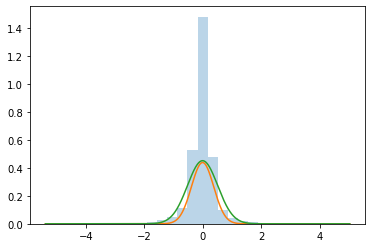

In [36]:
plt.hist(feature_data[:,1].cpu(), bins=30, density=True, alpha=0.3)

X = torch.arange(feature_data[:,1].min(),feature_data[:,1].max(),0.01)
for k in range(K):
    posterior = dist.Normal(pyro.param("auto_x_locs")[k], pyro.param("auto_x_scale")[k])
    Y = torch.exp(posterior.log_prob(X))
    plt.plot(X.cpu().numpy(), Y.data.cpu().numpy()*pyro.param("auto_weights")[k].item(), label=k)
#plt.ylim(0,0.001)
plt.show()

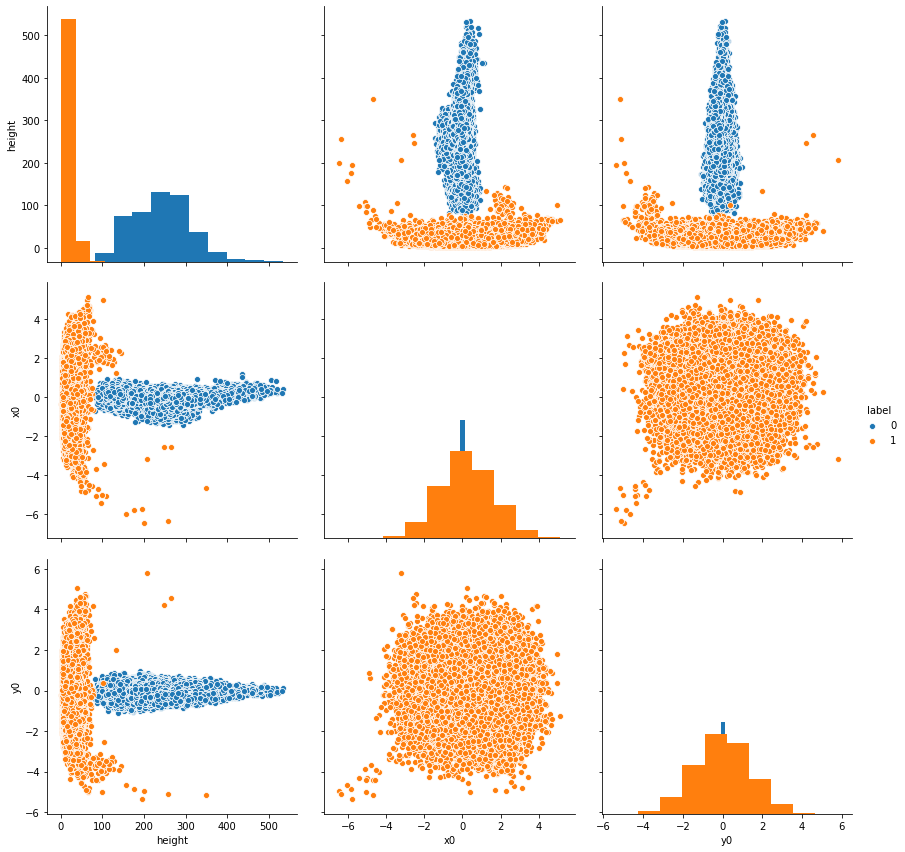

In [191]:
sns.pairplot(dset, vars=["height", "x0", "y0"], diag_kind="hist", hue="label", height=4)
plt.show()

# Visualize Data

## View glimpse images

In [15]:
aoi_list = aoi_df.index
frame_list = drift_df.index

interact(view_glimpse, frame=frame_list, aoi=aoi_list,
         aoi_df=fixed(aoi_df.loc[aoi_list]), drift_df=fixed(drift_df.loc[frame_list]), 
         header=fixed(header), path_glimpse=fixed(path_header),
         selected_aoi=True, all_aois=True, label=False, offset=False)

interactive(children=(Dropdown(description='frame', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

<function utils.view_glimpse(frame, aoi, aoi_df, drift_df, header, path_glimpse, selected_aoi, all_aois, label, offset)>

## View AoI

In [16]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_aoi_summary, aoi=aoi_widget, data=fixed(data))

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_aoi_summary(aoi, data, show_class=False)>

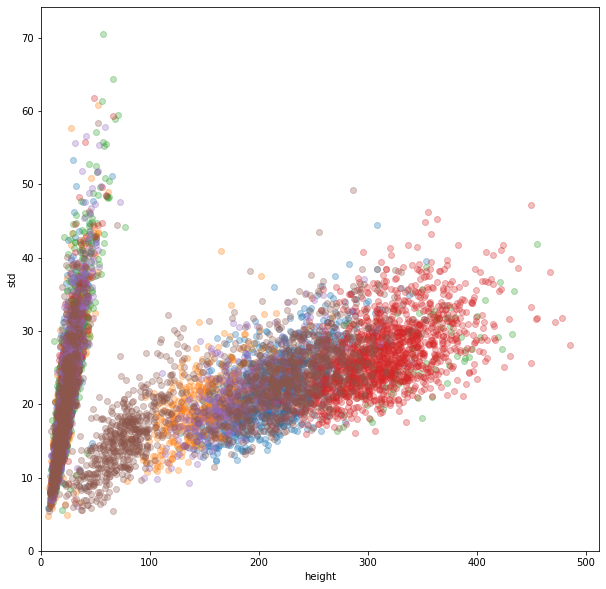

In [14]:
plt.figure(figsize=(10,10))
sd = np.sqrt(data.h[21].cpu().numpy() / data.h_beta[21].cpu().numpy())
plt.scatter(data.h[21].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.h[2].cpu().numpy() / data.h_beta[2].cpu().numpy())
plt.scatter(data.h[2].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.h[30].cpu().numpy() / data.h_beta[30].cpu().numpy())
plt.scatter(data.h[30].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.h[43].cpu().numpy() / data.h_beta[43].cpu().numpy())
plt.scatter(data.h[43].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.h[105].cpu().numpy() / data.h_beta[105].cpu().numpy())
plt.scatter(data.h[105].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.h[185].cpu().numpy() / data.h_beta[185].cpu().numpy())
plt.scatter(data.h[185].cpu().numpy(), sd, alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel("height")
plt.ylabel("std")
plt.show()

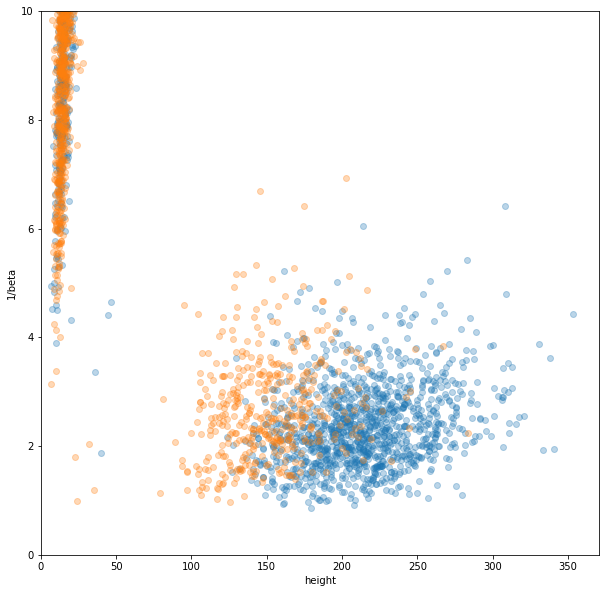

In [52]:
plt.figure(figsize=(10,10))

plt.scatter(data.h[21].cpu().numpy(), 1/data.h_beta[21].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[2].cpu().numpy(), 1/data.h_beta[2].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[30].cpu().numpy(), 1/data.h_beta[30].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[43].cpu().numpy(), 1/data.h_beta[43].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[105].cpu().numpy(), 1/data.h_beta[105].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[185].cpu().numpy(), 1/data.h_beta[185].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[210].cpu().numpy(), 1/data.h_beta[210].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[75].cpu().numpy(), 1/data.h_beta[75].cpu().numpy(), alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel("height")
plt.ylabel("1/beta")
plt.show()

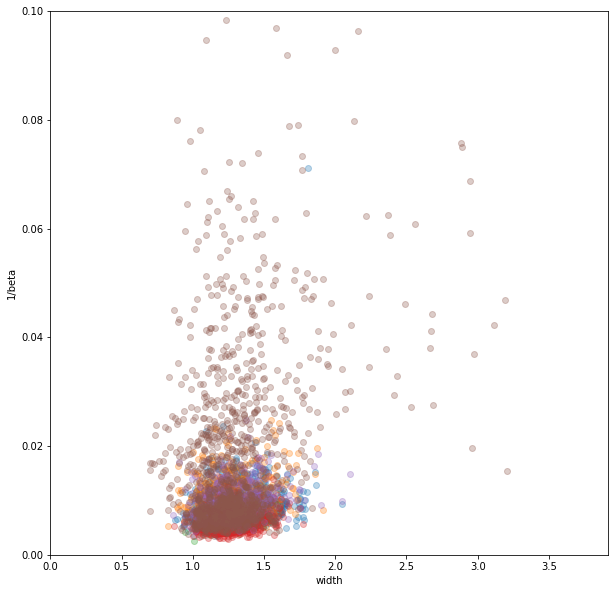

In [48]:
plt.figure(figsize=(10,10))

plt.scatter(data.w[21].cpu().numpy(), 1/data.w_beta[21].cpu().numpy(), alpha=0.3)

plt.scatter(data.w[2].cpu().numpy(), 1/data.w_beta[2].cpu().numpy(), alpha=0.3)

plt.scatter(data.w[30].cpu().numpy(), 1/data.w_beta[30].cpu().numpy(), alpha=0.3)

plt.scatter(data.w[43].cpu().numpy(), 1/data.w_beta[43].cpu().numpy(), alpha=0.3)

plt.scatter(data.w[105].cpu().numpy(), 1/data.w_beta[105].cpu().numpy(), alpha=0.3)

plt.scatter(data.w[185].cpu().numpy(), 1/data.w_beta[185].cpu().numpy(), alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,0.1)
plt.xlabel("width")
plt.ylabel("1/beta")
plt.show()

In [88]:
from scipy import stats
sd = np.sqrt(data.w[21,:1100].cpu().numpy() / data.w_beta[21,:1100].cpu().numpy())
mean = data.w[21,:1100].cpu().numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(mean,sd)
slope

0.06105441157408005

In [92]:
0.88648 / 0.8075912, 0.077951 / 0.061054

(1.0976840758046895, 1.2767550037671571)

In [89]:
sd = np.sqrt(data.h[21,:1100].cpu().numpy() / data.h_beta[21,:1100].cpu().numpy())
mean = data.h[21,:1100].cpu().numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(mean,sd)
slope

0.07795175918071744

In [90]:
sd = np.sqrt(data.w[21,1300:].cpu().numpy() / data.w_beta[21,1300:].cpu().numpy())
mean = data.w[21,1300:].cpu().numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(mean,sd)
slope

0.8075912684902424

In [91]:
sd = np.sqrt(data.h[21,1300:].cpu().numpy() / data.h_beta[21,1300:].cpu().numpy())
mean = data.h[21,1300:].cpu().numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(mean,sd)
slope

0.8864820874330411

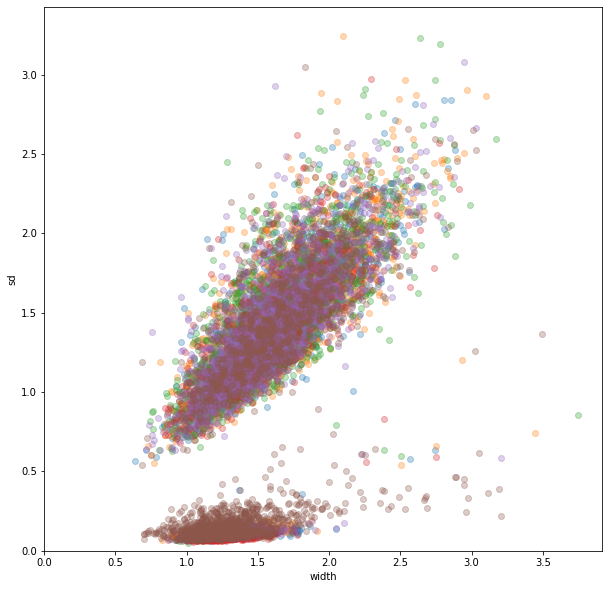

In [11]:
plt.figure(figsize=(10,10))
sd = np.sqrt(data.w[21].cpu().numpy() / data.w_beta[21].cpu().numpy())
mean = data.w[21].cpu().numpy()
plt.scatter(mean, sd, alpha=0.3)

sd = np.sqrt(data.w[2].cpu().numpy() / data.w_beta[2].cpu().numpy())
plt.scatter(data.w[2].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.w[30].cpu().numpy() / data.w_beta[30].cpu().numpy())
plt.scatter(data.w[30].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.w[43].cpu().numpy() / data.w_beta[43].cpu().numpy())
plt.scatter(data.w[43].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.w[105].cpu().numpy() / data.w_beta[105].cpu().numpy())
plt.scatter(data.w[105].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.w[185].cpu().numpy() / data.w_beta[185].cpu().numpy())
plt.scatter(data.w[185].cpu().numpy(), sd, alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel("width")
plt.ylabel("sd")
plt.show()

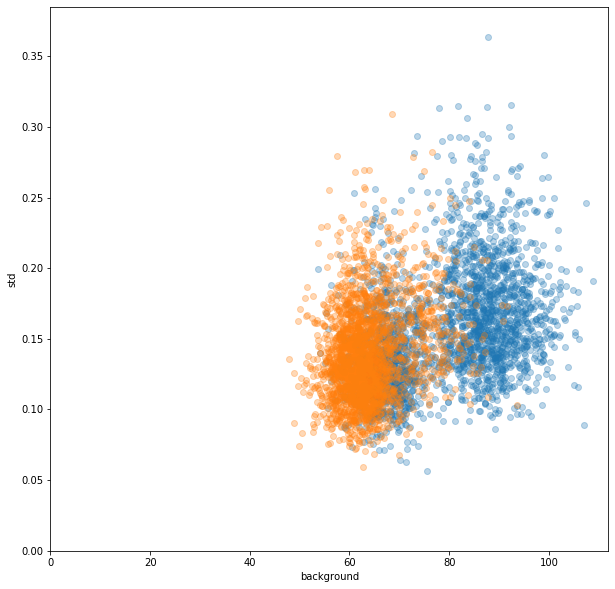

In [26]:
plt.figure(figsize=(10,10))
#sd = np.sqrt(data.b[21].cpu().numpy() / data.b_beta[21].cpu().numpy())
#plt.scatter(data.b[21].cpu().numpy(), 1/data.b_beta[21].cpu().numpy(), alpha=0.3)

#sd = np.sqrt(data.b[2].cpu().numpy() / data.b_beta[2].cpu().numpy())
#plt.scatter(data.b[2].cpu().numpy(), 1/data.b_beta[2].cpu().numpy(), alpha=0.3)

#sd = np.sqrt(data.b[30].cpu().numpy() / data.b_beta[30].cpu().numpy())
#plt.scatter(data.b[30].cpu().numpy(), 1/data.b_beta[30].cpu().numpy(), alpha=0.3)

#sd = np.sqrt(data.b[43].cpu().numpy() / data.b_beta[43].cpu().numpy())
plt.scatter(data.b[43].cpu().numpy(), 1/data.b_beta[43].cpu().numpy(), alpha=0.3)

#sd = np.sqrt(data.b[105].cpu().numpy() / data.b_beta[105].cpu().numpy())
plt.scatter(data.b[105].cpu().numpy(), 1/data.b_beta[105].cpu().numpy(), alpha=0.3)

#sd = np.sqrt(data.b[185].cpu().numpy() / data.b_beta[185].cpu().numpy())
#plt.scatter(data.b[185].cpu().numpy(), 1/data.b_beta[185].cpu().numpy(), alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel("background")
plt.ylabel("std")
plt.show()

In [49]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_feature_summary, aoi=aoi_widget, data=fixed(data), show_class=False)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_feature_summary(aoi, data, show_class=False)>

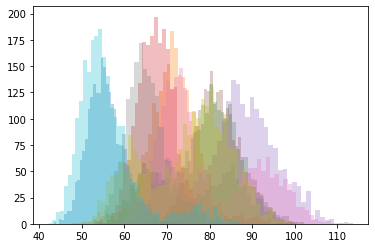

In [34]:
plt.hist(data.feature[0,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[10,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[20,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[30,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[40,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[50,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[60,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[70,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[150,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[200,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.show()

In [25]:
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)])

aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_aoi, aoi=aoi_widget, frame=frame_widget, data=fixed(data), show_class=False)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_aoi(aoi, frame, data, show_class=False)>

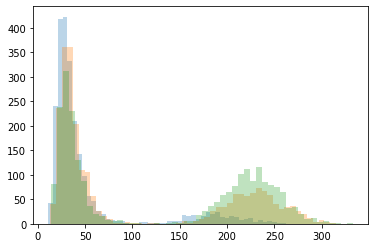

In [15]:
#plt.hist(data.feature[28,:,0].cpu(), bins=50, alpha=0.3)
#plt.hist(data.feature[0,:,0].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[1,:,0].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[13,:,0].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[21,:,0].cpu(), bins=50, alpha=0.3)
#plt.plot(data.intensity.numpy()[307])
plt.show()

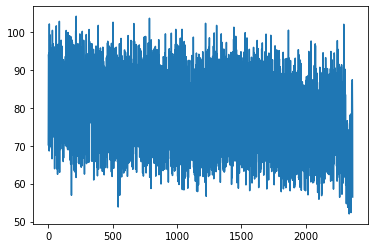

In [26]:
plt.plot(pyro.param("background_v").squeeze().detach().numpy()[24])

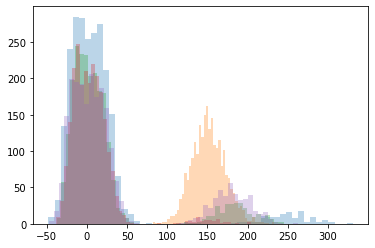

In [27]:
plt.hist(data.feature[28,:,0].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[0,:,0].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[1,:,0].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[3,:,0].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[5,:,0].cpu(), bins=50, alpha=0.3)
#plt.plot(data.intensity.numpy()[307])
plt.show()

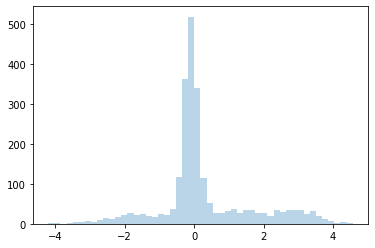

In [37]:
#plt.hist(data.feature[28,:,0].cpu(), bins=50, alpha=0.3)
#plt.hist(data.feature[0,:,1].cpu(), bins=50, alpha=0.3)
#plt.hist(data.feature[1,:,1].cpu(), bins=50, alpha=0.3)
#plt.hist(data.feature[3,:,1].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[14,:,1].cpu(), bins=50, alpha=0.3)
#plt.plot(data.intensity.numpy()[307])
plt.show()

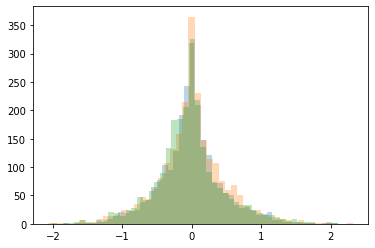

In [32]:
#plt.hist(data.feature[28,:,0].cpu(), bins=50, alpha=0.3)
#plt.hist(data.feature[0,:,1].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[1,:,1].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[3,:,1].cpu(), bins=50, alpha=0.3)
plt.hist(data.feature[5,:,1].cpu(), bins=50, alpha=0.3)
#plt.plot(data.intensity.numpy()[307])
plt.show()

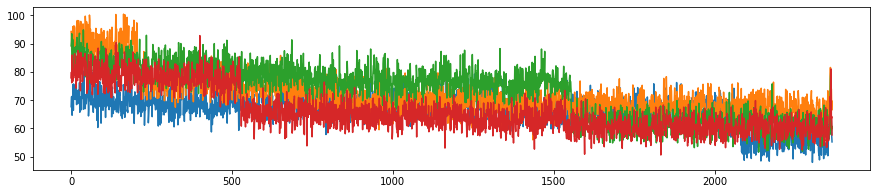

In [18]:
plt.figure(figsize=(15,3))
plt.plot(pyro.param("auto_background").cpu().detach().squeeze().numpy()[16])
plt.plot(pyro.param("auto_background").cpu().detach().squeeze().numpy()[17])
plt.plot(pyro.param("auto_background").cpu().detach().squeeze().numpy()[18])
plt.plot(pyro.param("auto_background").cpu().detach().squeeze().numpy()[19])
plt.show()

## View offset
TODO: Use EmpiricalDistribution for the offset. Therefore the overall camera signal will be the sum of two random variables = offset(empirical) + signal(gamma).
TODO2: Look pixel by pixel

In [24]:
offset = get_offset(drift_df.index, header, path_header)
samples, counts = np.unique(offset, return_counts=True)

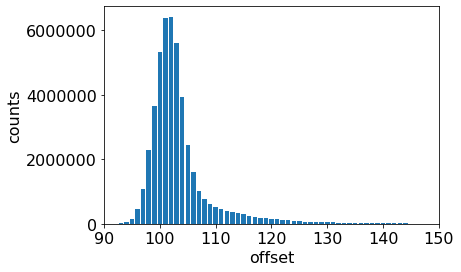

In [52]:
plt.bar(samples, counts)
plt.ylabel("counts")
plt.xlabel("offset")
plt.xlim(90,150)
plt.show()

In [54]:
save_offset = np.zeros((len(samples),2))
save_offset[:,0] = samples
save_offset[:,1] = counts
np.savetxt("offset.csv", save_offset, delimiter=",")

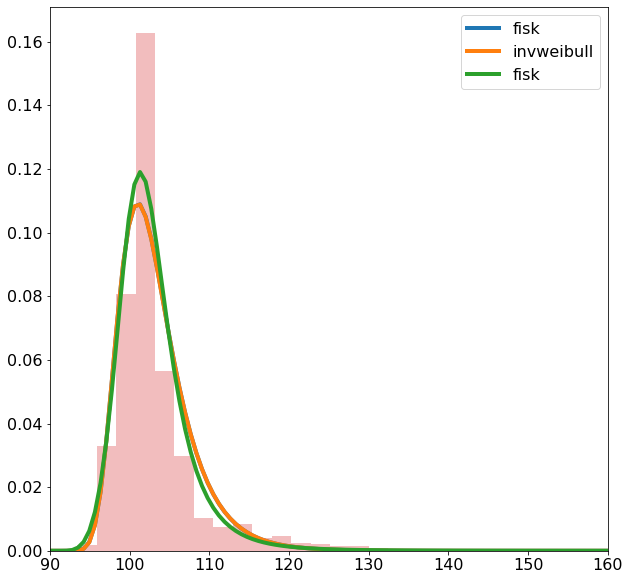

In [106]:
plt.figure(figsize=(10,10))
plt.plot(x, burr.pdf(x, *pars_burr), lw=4, label="fisk")
plt.plot(x, invweibull.pdf(x, *pars_weibull), lw=4, label="invweibull")

#pars = fisk.fit(off)
plt.plot(x, fisk.pdf(x, *pars), lw=4, label="fisk")

plt.hist(off, bins=50, density=True, alpha=0.3)
plt.xlim(90,160)
plt.legend()
plt.show()

# Modelv1

In [11]:
# init
#model_name = "Feature"
model_name = "v1-gf"
# gaussian spot model + gamma noise model
spot_models[model_name] = Modelv1
noise_models[model_name] = GammaNoise

Model = type(model_name, (spot_models[model_name],noise_models[model_name]),{}) # change here

models[model_name] = Model(data, K=2) # change here

writers[model_name] = SummaryWriter(log_dir=os.path.join(path,"runs/Modelv1/{}/K{}".format(
    models[model_name].__class__.__name__, models[model_name].K)))

In [12]:
model_name = "v1-gf"
#model_name = "GammaOffsetCPUN16F32"

model = models[model_name]
writer = writers[model_name]

## Train the model

In [13]:
pyro.clear_param_store()

optim = pyro.optim.Adam({"lr": 0.005, "betas": [0.9, 0.999]})
elbo = TraceEnum_ELBO(max_plate_nesting=5)
#elbo = Trace_ELBO()
svi = SVI(model.model, model.guide, optim, loss=elbo)


writer.add_text("Spot Model", inspect.getsource(spot_models[model_name])) # change here
writer.add_text("Noise Model", inspect.getsource(noise_models[model_name])) # change here

epoch_count = 0
batch_size = 16
#write_summary(epoch_count, batch_size, model, svi, writer, feature=False, mcc=False)

In [14]:
n_epochs = 10

for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    for batch_idx in DataLoader(Sampler(model.N), batch_size=16, shuffle=True):
        for frame_idx in DataLoader(Sampler(model.F), batch_size=32, shuffle=True):
            loss = svi.step(batch_idx, frame_idx)
            epoch_loss += loss * len(batch_idx) * len(frame_idx) / (model.N * model.F)
            #print(pyro.param("x0_scale_v").item())
        
    #if not epoch_count % 5:
    #print(epoch_loss)
    write_summary(epoch_count, epoch_loss, model, svi, writer, feature=False, mcc=False)
    epoch_count += 1
    
# cpu 22s/it
# gpu 14s/it double sampling

 30%|███       | 3/10 [03:26<08:06, 69.51s/it]

KeyboardInterrupt: 

In [ ]:
sd = loc / beta; beta = loc / sd

In [23]:
pyro.param("width_alpha_v").squeeze() / pyro.param("width_beta_v").squeeze()

tensor(0.6350, grad_fn=<DivBackward0>)

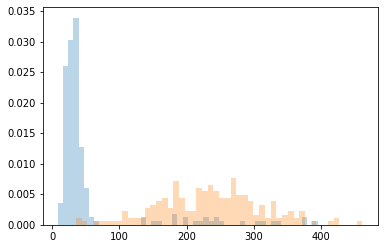

In [51]:
plt.hist((pyro.param("h_loc").squeeze() / pyro.param("h_beta").squeeze()).detach().cpu()[0], density=True, bins=50, alpha=0.3)
plt.hist((pyro.param("h_loc").squeeze() / pyro.param("h_beta").squeeze()).detach().cpu()[1], density=True, bins=50, alpha=0.3)
#plt.hist(data.feature[:,:,0].reshape(-1).cpu(), density=True, bins=50, alpha=0.3)
plt.show()

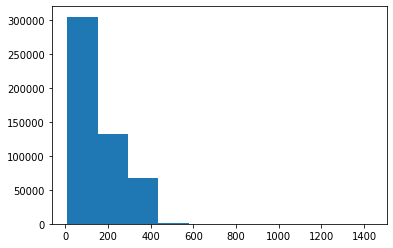

In [42]:
plt.hist(data.feature[:,:,0].reshape(-1).cpu())
plt.show()

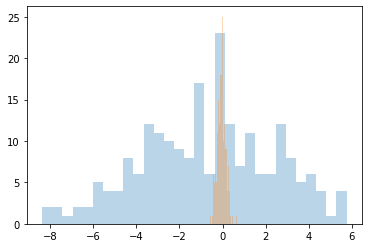

In [39]:
plt.hist(pyro.param("x_loc").squeeze().detach().cpu()[0], bins=30, alpha=0.3)
plt.hist(pyro.param("x_loc").squeeze().detach().cpu()[1], bins=30, alpha=0.3)
plt.show()

In [28]:
pyro.param("h_loc").squeeze().shape

torch.Size([2, 214])

In [20]:
pyro.param("b_loc").squeeze()

tensor([51.3640, 51.9216, 51.8492, 54.1319, 58.6619, 63.3741, 54.8199, 57.6719,
        48.4787, 50.8589, 73.8913, 61.9544, 60.0811, 67.3276, 59.3503, 56.0918,
        67.0401, 69.8300, 75.8031, 64.8656, 66.3644, 59.6632, 73.4849, 76.0283,
        78.1995, 66.6448, 75.4370, 69.9005, 59.1795, 80.5068, 75.3881, 76.3025,
        72.7876, 68.7119, 59.0395, 60.8643, 68.4246, 73.9184, 68.6615, 72.6683,
        84.2995, 72.7344, 71.5738, 73.4205, 69.4212, 74.6387, 68.0772, 69.6994,
        75.6963, 88.0029, 84.2460, 81.5782, 70.4098, 70.1380, 81.8855, 62.5222,
        73.2976, 81.5322, 73.0511, 70.0084, 79.8635, 84.3217, 84.0014, 73.3703,
        69.7217, 73.2475, 83.7754, 70.7532, 58.6198, 76.1545, 65.5409, 71.5540,
        75.5649, 80.5390, 77.7487, 80.6591, 65.0890, 74.7228, 71.7125, 91.0726,
        73.4370, 84.8178, 69.4626, 63.9586, 85.1827, 75.1544, 64.5103, 77.4414,
        66.5727, 74.5583, 66.6921, 73.2701, 98.0681, 82.3591, 72.9939, 77.9451,
        69.8754, 87.7750, 59.2794, 99.06

In [44]:
locs = torch.ones(2, 16, 32, model.D, model.D) * pyro.param("background_v")[:,:16]
locs += torch.cat((torch.zeros(1,16,32,model.D,model.D), model.gaussian_spot(torch.arange(16), torch.arange(500,532), 
                    pyro.param("height_v")[:,:16], pyro.param("width_v")[:,:16], 
                    pyro.param("x0_v")[:,:16], pyro.param("y0_v")[:,:16])), 0)

In [40]:
pyro.param("background_v").squeeze().cpu().detach().numpy()[2]

55.878998

## MCMC

In [13]:
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import predictive, initialize_model

In [14]:
nuts_kernel = NUTS(model.mcmc_model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=300)

In [29]:
#mcmc.run()

### Simulations

In [17]:
sample_data = model.sample()

In [18]:
for k in range(model.K):
    writer.add_histogram("hist_class_{}".format(k), model.data[torch.tensor(
        (model.data.info["predictions"] == k).values)].reshape(-1).cpu(), 0)
    writer.add_histogram("hist_class_{}".format(k), sample_data[torch.tensor(
        (model.data.info["predictions"] == k).values)].reshape(-1).cpu(), 1)
    
    #for i in range(model.D**2):
    #    x, y = divmod(i, model.D)
    #    writer.add_histogram("pixel_{}_{}_class_{}".format(x,y,k), model.data[torch.tensor((model.data.info["predictions"] == k).values)]
    #     [:, x, y], 0)
    #    writer.add_histogram("pixel_{}_{}_class_{}".format(x,y,k), sample_data[torch.tensor((model.data.info["predictions"] == k).values)]
    #     [:, x, y], 1)

# Classification

In [21]:
# class based on the highest probability
model.data.predictions = pyro.param("z_probs").cpu().squeeze().detach().argmax(dim=2)
# probabilities
model.data.probs = pyro.param("z_probs").squeeze().detach().cuda()

In [26]:
torch.save(data.probs, os.path.join(path, "probs.pt"))

In [25]:
torch.nonzero((pyro.param("z_probs").cpu().squeeze()[...,0] > 0.3) & (pyro.param("z_probs").cpu().squeeze()[...,0] < 0.7))[:,0].unique()

tensor([  3,   7,  28,  30,  48,  55,  57,  58,  74,  78,  83,  84,  99, 103,
        111, 112, 118, 120, 124, 137, 147, 155, 156, 157, 160, 161, 169, 175,
        176, 182, 185, 186, 195, 201, 210], device='cpu')

In [18]:
torch.nonzero((pyro.param("z_probs").cpu().squeeze()[...,0] > 0.3) & (pyro.param("z_probs").cpu().squeeze()[...,0] < 0.7))[:,0].unique()

tensor([ 15,  74,  82,  99, 109, 176, 185, 192], device='cpu')

In [23]:
torch.nonzero((pyro.param("z_probs").cpu().squeeze()[...,0] > 0.3) & (pyro.param("z_probs").cpu().squeeze()[...,0] < 0.7))[:,0].unique()

tensor([ 74,  99, 176, 185], device='cpu')

In [28]:
-2.4487e+8 / model.N / model.F

-483.6231345936594

In [28]:
#pyro.param("x_scale").squeeze()[:,42]
# aoi 24 16

In [22]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_aoi_summary, aoi=aoi_widget, data=fixed(data), show_class=True)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_aoi_summary(aoi, data, show_class=False)>

In [24]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_feature_summary, aoi=aoi_widget, data=fixed(data))

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_feature_summary(aoi, data, show_class=False)>

In [ ]:
# aoi 116

(-5, 5)

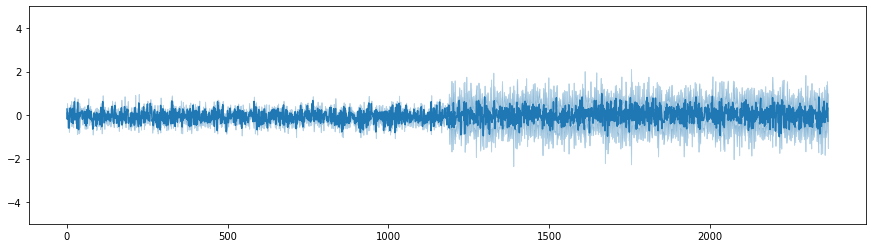

In [29]:
plt.figure(figsize=(15,4))
mean = pyro.param("x_loc").cpu().squeeze().detach().numpy()[21]
sd = pyro.param("x_scale").cpu().squeeze().detach().numpy()[21]
plt.plot(data.drift.index, mean)
plt.fill_between(data.drift.index, mean - sd, mean + sd, color='C0', alpha=0.3)
plt.ylim(-5,5)

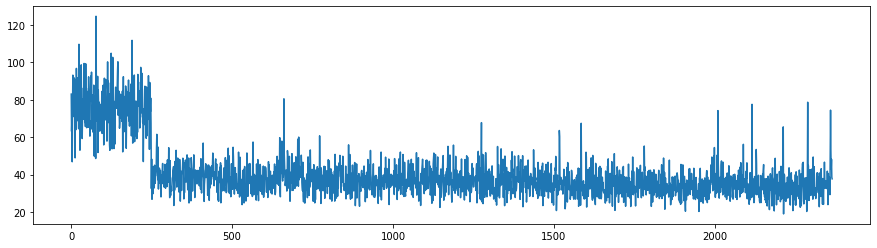

In [40]:
plt.figure(figsize=(15,4))
#plt.plot(pyro.param("b_loc").squeeze().cpu().detach().numpy()[1])
#plt.plot(pyro.param("b_loc").squeeze().cpu().detach().numpy()[2])
plt.plot(pyro.param("b_loc").squeeze().cpu().detach().numpy()[39])
plt.show()

In [37]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_feature_summary, aoi=aoi_widget, data=fixed(data))

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_feature_summary(aoi, data, show_class=False)>

In [22]:
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(model.data.drift.index)])

aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(model.data.target.index)])

interact(view_aoi, aoi=aoi_widget, frame=frame_widget, data=fixed(model.data), show_class=True)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_aoi(aoi, frame, data, show_class=False)>

In [26]:
from matplotlib.colors import to_rgba_array
to_rgba_array("C{}".format(0))[0,:3] 

array([0.12156863, 0.46666667, 0.70588235])

In [27]:
data.probs.cpu().numpy()[0,0,0]

3.3166183e-05

In [ ]:
# aoi 58 frame 35 double spot
# aoi 31 frame 83 -> solved by local bg
# aoi 4
# aoi 8 frame 41
# aoi 29 frame 1 (dirt at left bottom frame 330)
# aoi 10 nice!
# aoi 13 frame 1192 interesting case
# aoi 23 very bright in the beginning

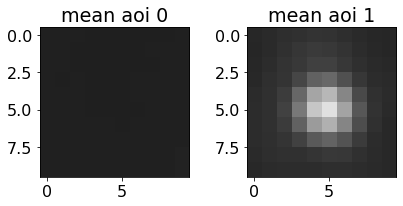

In [43]:
view_aoi_class_average(model.data, model.K)

# Fitting results

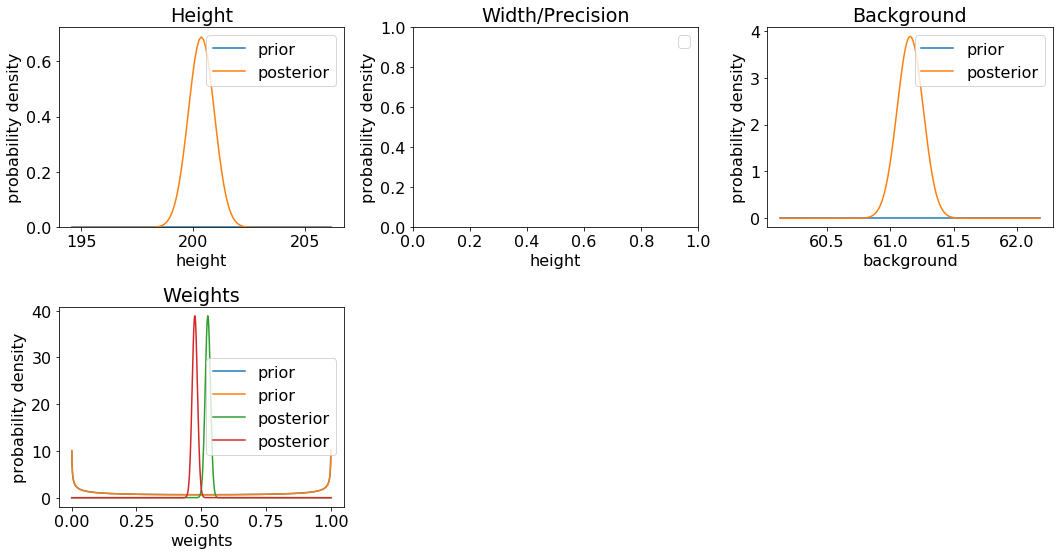

In [67]:
plt.figure(figsize=(15,8))

X = torch.arange(pyro.param("height_loc").item()-pyro.param("height_scale").item()*10, pyro.param("height_loc").item()+pyro.param("height_scale").item()*10,0.1)
#X = torch.arange(190,240,0.1)
prior = dist.HalfNormal(500.)
posterior = dist.Normal(pyro.param("height_loc"), pyro.param("height_scale"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,1)
plt.plot(X.cpu().numpy(), Y_prior.data.cpu().numpy(), label="prior")
plt.plot(X.cpu().numpy(), Y_posterior.data.cpu().numpy(), label="posterior")
#plt.plot([h_true, h_true], [0., Y_posterior.max().item()], 'k--', label="true")
plt.title("Height")
plt.ylabel("probability density")
plt.xlabel("height")
plt.ylim(0,)
plt.legend()


X = torch.arange(0.5,2.,0.01)
prior = dist.Gamma(1., 0.1)
#posterior = dist.Gamma(pyro.param("width_alpha"), pyro.param("width_beta"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,2)
plt.title("Width/Precision")
plt.ylabel("probability density")
plt.xlabel("height")
plt.legend()


X = torch.arange(pyro.param("background_loc").item()-pyro.param("background_scale").item()*10, pyro.param("background_loc").item()+pyro.param("background_scale").item()*10,0.01)
prior = dist.HalfNormal(1000.)
posterior = dist.Normal(pyro.param("background_loc"), pyro.param("background_scale"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,3)
plt.plot(X.cpu().numpy(), Y_prior.data.cpu().numpy(), label="prior")
plt.plot(X.cpu().numpy(), Y_posterior.data.cpu().numpy(), label="posterior")
#plt.plot([b_true, b_true], [0., Y_posterior.max().item()], 'k--', label="true")
plt.title("Background")
plt.ylabel("probability density")
plt.xlabel("background")
plt.legend()

X = torch.stack((torch.arange(0,1,0.001), torch.arange(1,0,-0.001)), dim=1)
prior = dist.Dirichlet(0.5 * torch.ones(2))
posterior = dist.Dirichlet(pyro.param("weights_conc"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,4)
plt.plot(X.cpu().numpy(), Y_prior.data.cpu().numpy(), label="prior")
plt.plot(X.cpu().numpy(), Y_posterior.data.cpu().numpy(), label="posterior")
#plt.plot([pi_true[0], pi_true[0]], [0., Y_posterior.max().item()], 'k--')
#plt.plot([pi_true[1], pi_true[1]], [0., Y_posterior.max().item()], 'k--')
plt.title("Weights")
plt.ylabel("probability density")
plt.xlabel("weights")
plt.legend()




plt.tight_layout()
plt.show()

In [ ]:


def per_param_callable(module_name, param_name):
    if param_name in ["background_loc", "background_scale", "height_scale", "height_loc"]:
        return {"lr": 0.2, 'betas': [0.9, 0.999]}
    else:
        return {"lr": 0.05, 'betas': [0.9, 0.999]}
#optim = pyro.optim.ASGD({"lr":0.1})

In [ ]:
#trace = poutine.trace(gaussgamma.mixture_model).get_trace(gaussgamma.data[:], torch.arange(len(gaussgamma.data)))
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

In [ ]:
# load checkpoint
optim.load("checkpoints/gmm_aoi17_optim_2019-06-24_10:01:04.ckpt")
pyro.get_param_store().load("checkpoints/gmm_aoi17_param_2019-06-24_10:01:04.ckpt")
history = load_obj("checkpoints/gmm_aoi17_history_2019-06-24_10:01:04.pkl")

In [ ]:
# save checkpoint
st = datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d_%H:%M:%S')
optim.save("checkpoints/{}_aoi{}_optim_{}.ckpt".format(gmm.name, aoi, st))
pyro.get_param_store().save("checkpoints/{}_aoi{}_param_{}.ckpt".format(gmm.name, aoi, st))
save_obj(history, "checkpoints/{}_aoi{}_history_{}.pkl".format(gmm.name, aoi, st))